# Word Cloud & Keyword Analysis (YouTube Titles)

โน้ตบุ๊กนี้ช่วยสร้าง **Word Cloud, Top Keywords และ Bigram Analysis** จากคอลัมน์ `Title` ของไฟล์ CSV ที่ดึงมาจาก YouTube (เช่น โหนกระแส)

รองรับภาษาไทยโดยใช้ `pythainlp` และฟอนต์ไทย เช่น TH Sarabun, Noto Sans Thai, Leelawadee


##  ขั้นที่ 1 — ติดตั้งไลบรารี (ทำใน venv ของโปรเจกต์)
```bash
python -m pip install wordcloud pythainlp pandas matplotlib
```
หากไม่มีฟอนต์ไทยในเครื่อง → ติดตั้งฟอนต์ (เช่น TH Sarabun New) และแก้ `font_path` 
ในโค้ดด้านล่าง

In [ ]:
# pip install wordcloud pythainlp pandas matplotlib

## ขั้นที่ 2 — โหลดข้อมูล & หา Font ภาษาไทย

In [75]:
import pandas as pd
from matplotlib import font_manager

CSV_PATH = "Scarping_หลอนไดอารี่.csv"  # ปรับชื่อไฟล์ตามจริง
df = pd.read_csv(CSV_PATH, encoding="utf-8-sig")
df.head()

# ----- หา font ภาษาไทย -----
def find_thai_font():
    candidates = ["Sarabun", "TH Sarabun", "Noto Sans Thai", "Leelawadee", "Tahoma", "K2D"]
    for fpath in font_manager.findSystemFonts():
        lower = fpath.lower()
        if any(k.lower().replace(" ", "") in lower.replace(" ", "") for k in candidates):
            return fpath
    return None  # ถ้าไม่มี ให้ระบุ path เอง

THAI_FONT = find_thai_font()
print("Thai font:", THAI_FONT)


Thai font: C:\Users\Oatbarley\AppData\Local\Microsoft\Windows\Fonts\TH K2D July8 Bold.ttf


## ขั้นที่ 3 — ทำความสะอาดข้อความ & ตัดคำภาษาไทย

In [76]:
import re
from collections import Counter
from pythainlp import word_tokenize
from pythainlp.corpus import thai_stopwords

titles = df["Title"].dropna().astype(str).tolist()

# --- Normalizer helpers ---
PUNCT_TAIL = r"\.\,、，。!！\?？:：;；·•\-–—"   # trailing punctuation to strip
ZW = r"[\u200b\ufeff]"                          # zero-width
EMOJI_RE = re.compile(r"[\U0001F300-\U0001FAFF\U00002700-\U000027BF]")

def normalize_token(w: str) -> str:
    """Lowercase, strip hashtags/@, zero-width, trailing punct, and emojis."""
    w = w.strip()
    w = re.sub(r"^[#@]+", "", w)           
    w = re.sub(ZW, "", w)                  # remove zero-width
    w = re.sub(EMOJI_RE, "", w)            # remove common emojis
    w = re.sub(f"[{PUNCT_TAIL}]+$", "", w) # strip trailing punctuation variants
    return w.casefold()                    # case-insensitive

# --- Stopwords ---
stop_th = set(map(normalize_token, thai_stopwords()))
custom_stop_raw = {
    "ep","ตอน","ไดอารี่"
    # add more if needed: "ด่วน","exclusive","official"
}
channel_name_core = "หลอนไดอารี่"

custom_stop = set(map(normalize_token, custom_stop_raw))
stop_all = stop_th | custom_stop



# --- Cleaning ---
def clean_text(s: str) -> str:
    s = s.strip()
    s = re.sub(r"http\S+", " ", s)     # remove URLs
    s = re.sub(ZW, " ", s)             # remove zero-width
    # keep punctuation minimal so Thai tokenization isn't harmed
    s = re.sub(r"[(){}\[\]\|*\"'`~^=+<>@#$%&_]", " ", s)
    return s

# --- Tokenize & filter ---
tokens = []
NUMLIKE_RE = re.compile(r"^[0-9]+([.:/\-][0-9]+)*$")  # numbers, times, dates

for t in titles:
    t = clean_text(t)
    toks = word_tokenize(t, engine="newmm", keep_whitespace=False)
    for w in toks:
        nw = normalize_token(w)
        if len(nw) < 2:               # very short tokens
            continue
        if NUMLIKE_RE.match(nw):      # numbers/time/date-like strings
            continue
        if nw in stop_all:            # remove channel name & common filler
            continue
        tokens.append(nw)

freq = Counter(tokens)
print("Sample tokens:", tokens[:30])
print("Unique tokens:", len(freq))


Sample tokens: ['ผจญ', 'กองกอย', 'ล่า', 'แก้ว', 'หยาดน้ำค้าง', 'ภู', 'พาน', 'หลอน', '.293', 'เฮี้ยน', 'ผี', 'เลี้ยง', 'รัชกาล', 'หลอน', 'กระหัง', 'พระ', 'ครู', 'หลอน', '.292', 'หลอน', 'ย้อนยุค', '.1', 'หลอน', 'สงคราม', 'มหา', 'ครุฑ', 'ถล่ม', 'หิมพานต์', 'official', 'teaser']
Unique tokens: 1165


## ขั้นที่ 4 — Word Cloud + Top Keywords

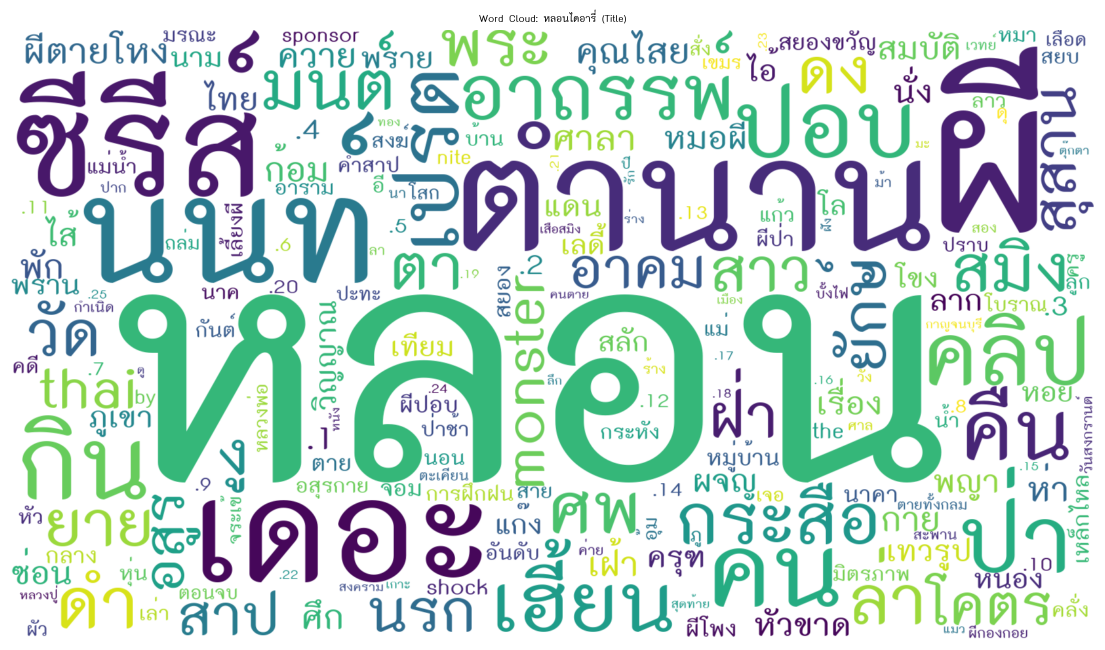

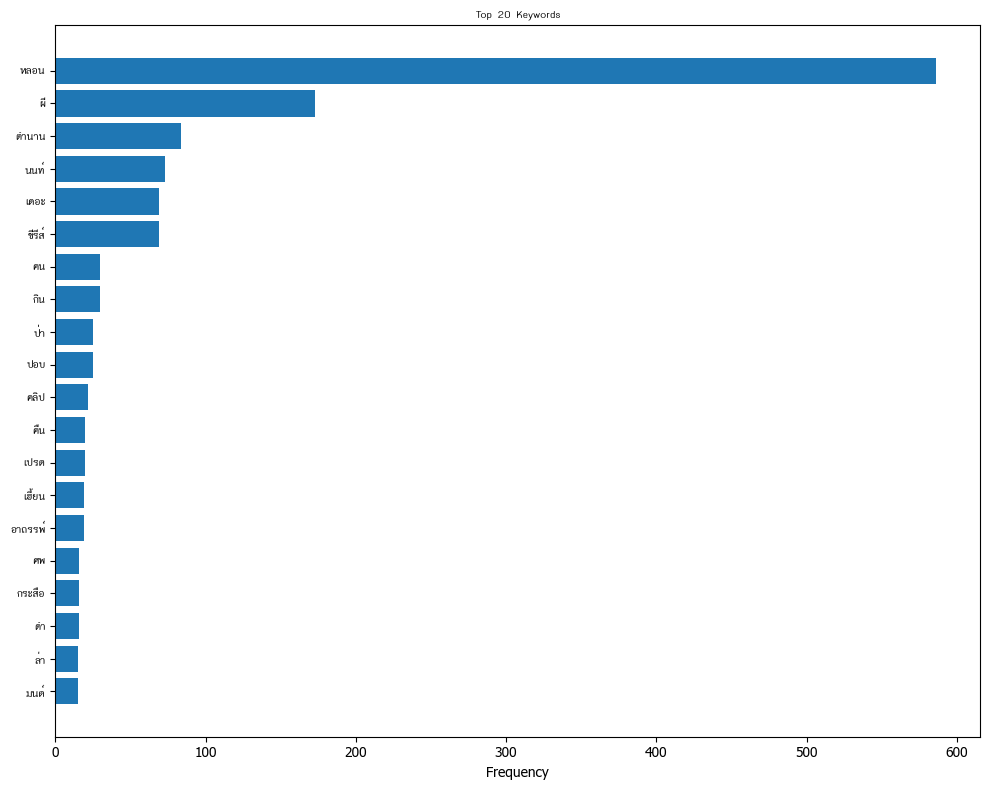

In [82]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# ----- Word Cloud -----
wc = WordCloud(
    font_path=THAI_FONT,
    width=1600, height=900,
    background_color="white",
    collocations=False
)
wc.generate_from_frequencies(freq)

plt.figure(figsize=(14,8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud: หลอนไดอารี่ (Title)", fontproperties=font_manager.FontProperties(fname=THAI_FONT) if THAI_FONT else None)
plt.show()

# ----- Top Keywords (barh) -----
TOP_N = 20
top_items = freq.most_common(TOP_N)
words = [w for w,c in top_items][::-1]
counts = [c for w,c in top_items][::-1]

plt.figure(figsize=(10,8))
plt.barh(words, counts)
if THAI_FONT:
    plt.yticks(fontproperties=font_manager.FontProperties(fname=THAI_FONT))
plt.title(f"Top {TOP_N} Keywords", fontproperties=font_manager.FontProperties(fname=THAI_FONT) if THAI_FONT else None)
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()


## ขั้นที่ 5 — Bigram Analysis (วลี 2 คำ)

In [78]:
def bigrams(seq):
    for i in range(len(seq)-1):
        yield (seq[i], seq[i+1])

bigrams_all = list(bigrams(tokens))
bigram_freq = Counter(bigrams_all)

TOP_BI = 30
for (w1,w2), c in bigram_freq.most_common(TOP_BI):
    print(f"{w1} {w2} : {c}")


นนท์ เดอะ : 69
เดอะ ซีรีส์ : 69
หลอน ผี : 28
ผี หลอน : 28
กิน คน : 20
คน หลอน : 19
หลอน คลิป : 17
หลอน หลอน : 16
ตำนาน ผี : 16
คลิป นนท์ : 12
หลอน thai : 11
thai monster : 11
หลอน ปอบ : 10
หลอน คืน : 9
สมิง หลอน : 9
ห่า ก้อม : 9
อสูร กาย : 9
มนต์ ดำ : 9
ศาลา พัก : 9
พัก สุสาน : 9
สุสาน หลอน : 9
นรก หลอน : 8
ควาย หลอน : 8
คลิป หลอน : 8
ก้อม โคตร : 8
ดำ หลอน : 8
ผี สาว : 8
ยักษ์ กิน : 7
เทวรูป กิน : 7
ผี ลาก : 7


## ขั้นตอนที่ 6 ทำการแยกประเภทของคลิป แปลงค่าเป็นวัน/เดือน/ปี และ แปลงค่าเวลาของคลิป

In [79]:
import pandas as pd
from datetime import datetime, timedelta
import re

def classify_content(title: str) -> str:
    title = str(title).lower().strip()

    categories = {
        "เรื่องผี": [r"\bผี\b", r"เปรต", r"สมิง", r"อาถรรพ์", r"ปอป", r"กระสือ", r"พญา"],
        "ตำนาน / ประวัติศาสตร์": [r"ตำนาน", r"ประวัติ", r"โบราณ", r"อารยธรรม", r"จังหวัด", r"ภาค"],
        "เรื่องจริง": [r"เรื่องจริง", r"เหตุการณ์จริง", r"เกิดขึ้นจริง", r"อิงเหตุการณ์", r"ประสบการณ์"],
        "นิยาย": [r"the shaman", r"นนท์เดอะซีรีส์", r"กฎ"],
        "เรื่องเล่า": [r"หลอน", r"อสูร", r"กฎ", r"ตาย", r"ศพ", r"มหาลัย", r"โรงแรม", r"โรงพยาบาล"],
    }

    for category, keywords in categories.items():
        for kw in keywords:
            if re.search(kw, title):
                return category
    return "อื่น ๆ"


def parse_published_date(date_str: str):
    if not isinstance(date_str, str):
        return None
    date_str = date_str.lower().replace('published on', '').strip()
    try:
        return datetime.strptime(date_str, '%b %d, %Y')
    except ValueError:
        return None


def parse_relative_date(date_str: str, now: datetime = None):
    if not isinstance(date_str, str):
        return None
    if now is None:
        now = datetime.now()

    date_str = date_str.lower().strip()
    match = re.match(r'(\d+)\s*(วินาที|นาที|ชั่วโมง|วัน|สัปดาห์|เดือน|ปี)(ที่ผ่านมา|ที่แล้ว)', date_str)
    if not match:
        return None

    num = int(match.group(1))
    unit = match.group(2)

    if unit == 'วินาที':
        return now - timedelta(seconds=num)
    elif unit == 'นาที':
        return now - timedelta(minutes=num)
    elif unit == 'ชั่วโมง':
        return now - timedelta(hours=num)
    elif unit == 'วัน':
        return now - timedelta(days=num)
    elif unit == 'สัปดาห์':
        return now - timedelta(weeks=num)
    elif unit == 'เดือน':
        return now - timedelta(days=num * 30)
    elif unit == 'ปี':
        return now - timedelta(days=num * 365)

    return None


# =======================
# Main
# =======================
df = pd.read_csv('Scarping_หลอนไดอารี่.csv')

# เพิ่มคอลัมน์ใหม่ Category
df["Category"] = df["Title"].apply(classify_content)

# แปลงคอลัมน์ Published
def convert_to_real_date(date_str):
    real_date = parse_published_date(date_str)
    if real_date is None:
        real_date = parse_relative_date(date_str)
    return real_date

df['Published'] = df['Published'].apply(convert_to_real_date)

# เซฟกลับไปที่ไฟล์เดิม
df.to_csv("Scarping_หลอนไดอารี่.csv", index=False, encoding="utf-8-sig")


## ขั้นตอนที่ 7 จัดอันดับคลิปที่ได้รับความนิยมสูงสุด

C:\Users\Oatbarley\AppData\Local\Temp\ipykernel_36684\408111705.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10, x="Views_Count", y="Title", palette="viridis")


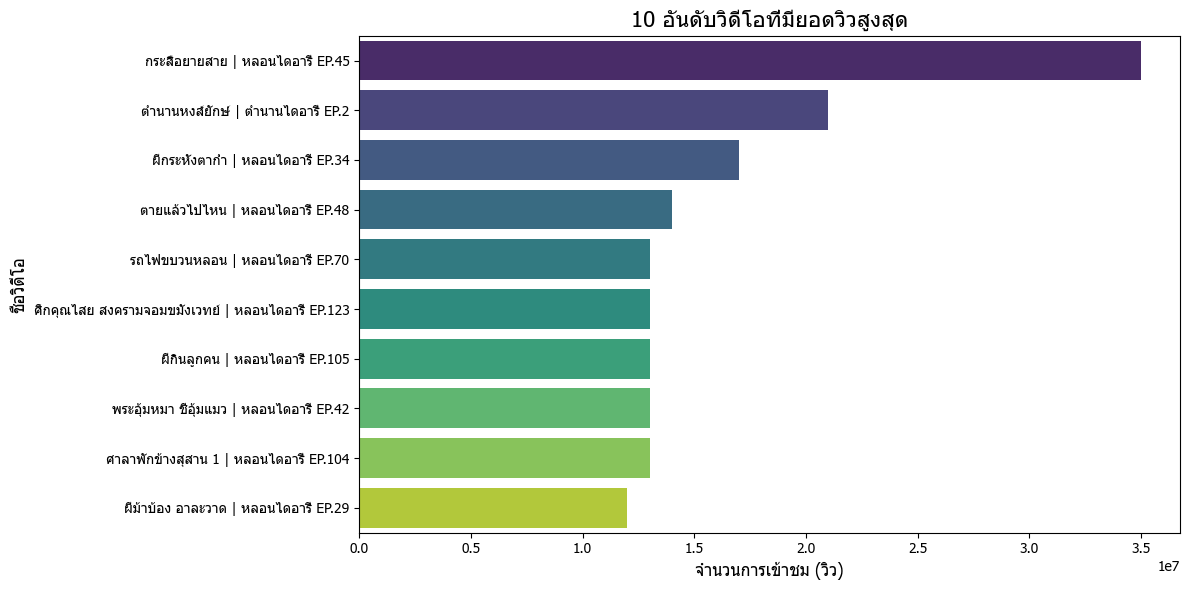

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ตั้งค่าให้ matplotlib รองรับภาษาไทย (Windows จะมี TH Sarabun หรือ AngsanaUPC)
plt.rcParams['font.family'] = 'Tahoma'   # ถ้าไม่มี Tahoma ลองใช้ 'TH Sarabun New' หรือ 'Angsana New'

# โหลด CSV
df = pd.read_csv(CSV_PATH, encoding="utf-8-sig")

# แปลง Views_Count เป็นตัวเลข
df = df.dropna(subset=["Views_Count"])
df["Views_Count"] = pd.to_numeric(df["Views_Count"], errors="coerce")

# --- Bar Chart: Top 10 วิดีโอ ---
top10 = df.sort_values(by="Views_Count", ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(data=top10, x="Views_Count", y="Title", palette="viridis")
plt.title("10 อันดับวิดีโอที่มียอดวิวสูงสุด", fontsize=16)
plt.xlabel("จำนวนการเข้าชม (วิว)", fontsize=12)
plt.ylabel("ชื่อวิดีโอ", fontsize=12)
plt.tight_layout()
plt.show()

## ขั้นตอนที่ 8 สร้างกราฟจำแนกประเภท

C:\Users\Oatbarley\AppData\Local\Temp\ipykernel_36684\1489438717.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="Category", y="Views_Count", estimator=lambda x: sum(x)/len(x), palette="viridis")


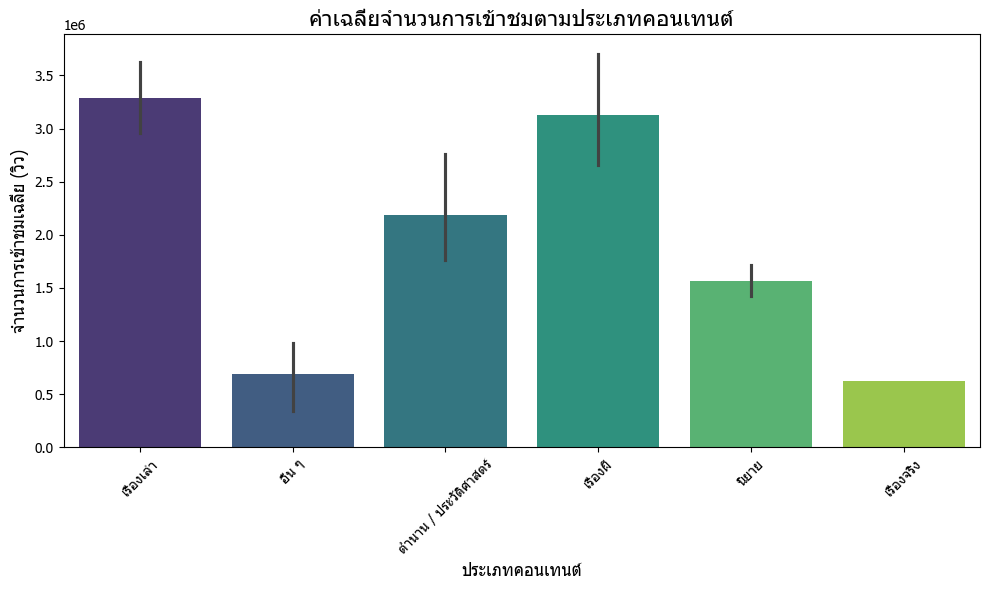

                Category   Views_Count
5             เรื่องเล่า  3.285725e+06
4               เรื่องผี  3.127126e+06
0  ตำนาน / ประวัติศาสตร์  2.190455e+06
1                  นิยาย  1.562812e+06
2                 อื่น ๆ  6.885716e+05
3             เรื่องจริง  6.200000e+05


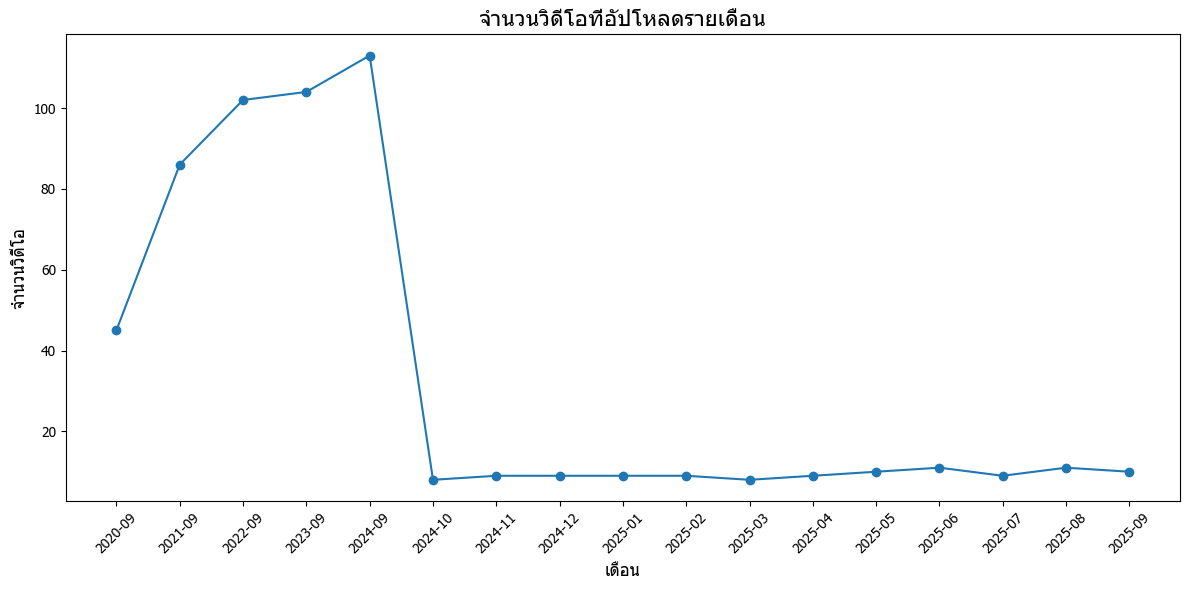

   YearMonth  Video_Count
0    2020-09           45
1    2021-09           86
2    2022-09          102
3    2023-09          104
4    2024-09          113
5    2024-10            8
6    2024-11            9
7    2024-12            9
8    2025-01            9
9    2025-02            9
10   2025-03            8
11   2025-04            9
12   2025-05           10
13   2025-06           11
14   2025-07            9
15   2025-08           11
16   2025-09           10


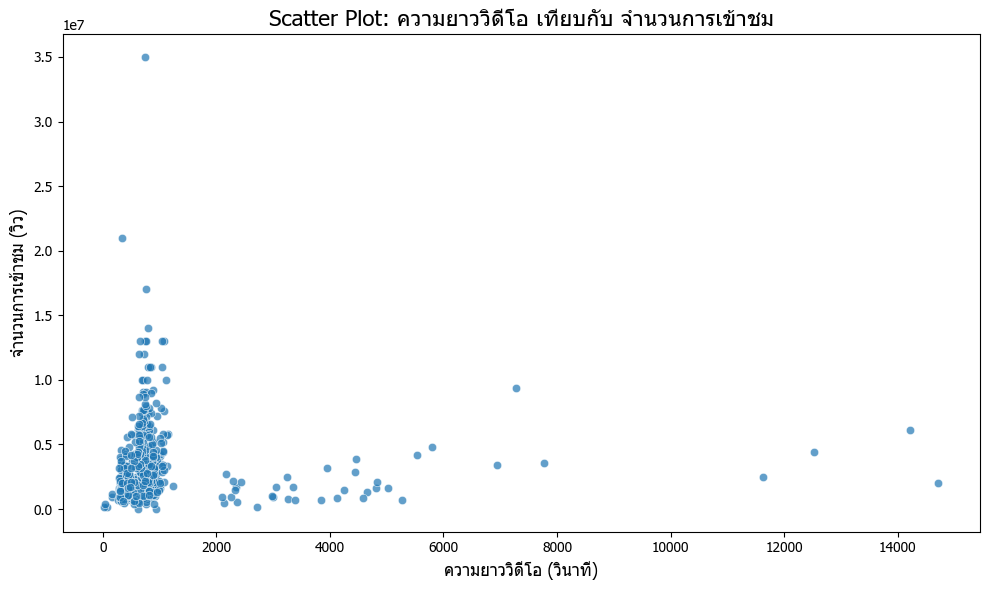

     Duration_Seconds  Views_Count
515               747     35000000
525               342     21000000
529               768     17000000
509               797     14000000
476               769     13000000
382              1071     13000000
420               750     13000000
519               656     13000000
422              1037     13000000
534               641     12000000
501               731     12000000
507               835     11000000
467               850     11000000
530              1048     11000000
485               803     11000000
522              1122     10000000
537               782     10000000
491               705     10000000
492               699     10000000
404              7275      9400000
ค่าเฉลี่ยของความยาววิดีโอของ 20 อันดับแรกที่มียอดเข้าชมสูงสุดคือ: 1121.40 วินาที


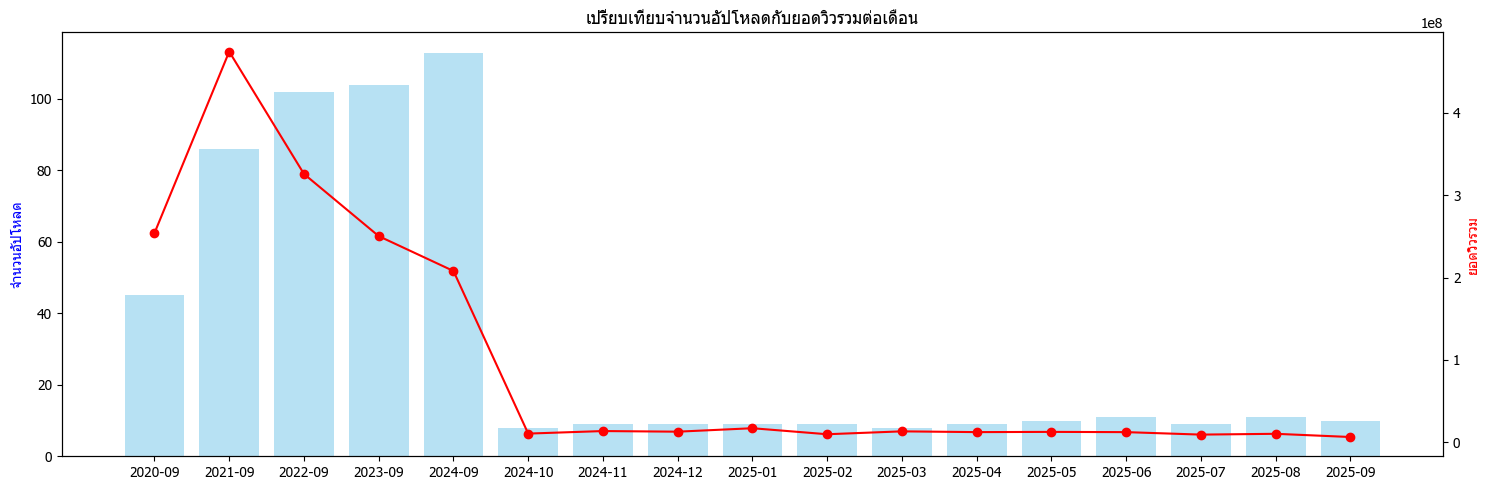

      month  upload_clip  total_views
0   2020-09           45    253959999
1   2021-09           86    474329996
2   2022-09          102    325799998
3   2023-09          104    250319999
4   2024-09          113    207989997
5   2024-10            8     10580000
6   2024-11            9     13660000
7   2024-12            9     12900000
8   2025-01            9     17090000
9   2025-02            9      9790000
10  2025-03            8     13300000
11  2025-04            9     12369999
12  2025-05           10     12650000
13  2025-06           11     12350000
14  2025-07            9      9350000
15  2025-08           11     10320000
16  2025-09           10      6429999


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ตั้งค่าให้ matplotlib รองรับภาษาไทย (Windows จะมี TH Sarabun หรือ AngsanaUPC)
plt.rcParams['font.family'] = 'Tahoma' 

# โหลดข้อมูล

df = pd.read_csv(CSV_PATH, encoding="utf-8-sig")

# --- เตรียมข้อมูล ---
# แปลง Views_Count เป็นตัวเลข
if "Views_Count" in df.columns:
    df["Views_Count"] = pd.to_numeric(df["Views_Count"], errors="coerce")

# แปลง Published เป็น datetime
if "Published" in df.columns:
    df["Published"] = pd.to_datetime(df["Published"], errors="coerce")

# --- 1. Bar Chart: ค่าเฉลี่ย Views ตามประเภทคอนเทนต์ ---
if "Category" in df.columns:
    plt.figure(figsize=(10,6))
    sns.barplot(data=df, x="Category", y="Views_Count", estimator=lambda x: sum(x)/len(x), palette="viridis")
    plt.title("ค่าเฉลี่ยจำนวนการเข้าชมตามประเภทคอนเทนต์", fontsize=16)
    plt.xlabel("ประเภทคอนเทนต์", fontsize=12)
    plt.ylabel("จำนวนการเข้าชมเฉลี่ย (วิว)", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    category_avg_views = df.groupby('Category')['Views_Count'].mean().reset_index()
    sorted_categories = category_avg_views.sort_values(by='Views_Count', ascending=False)
    print(sorted_categories)

else:
    print("ไม่พบคอลัมน์ Category ในข้อมูล")

# --- 2. Line Chart: จำนวนวิดีโอที่อัปโหลดรายเดือน ---
if "Published" in df.columns:
    df_month = df.dropna(subset=["Published"]).copy()
    df_month["YearMonth"] = df_month["Published"].dt.to_period("M")
    uploads_per_month = df_month.groupby("YearMonth").size().reset_index(name="Video_Count")

    plt.figure(figsize=(12,6))
    plt.plot(uploads_per_month["YearMonth"].astype(str), uploads_per_month["Video_Count"], marker="o")
    plt.title("จำนวนวิดีโอที่อัปโหลดรายเดือน", fontsize=16)
    plt.xlabel("เดือน", fontsize=12)
    plt.ylabel("จำนวนวิดีโอ", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print(uploads_per_month)
else:
    print("ไม่พบคอลัมน์ Published ในข้อมูล")

# --- 3. Scatter Plot: Duration เทียบกับ Views ---
if "Duration_Seconds" in df.columns and "Views_Count" in df.columns:
    df_duration = df.dropna(subset=["Duration_Seconds", "Views_Count"]).copy()

    plt.figure(figsize=(10,6))
    sns.scatterplot(data=df_duration, x="Duration_Seconds", y="Views_Count", alpha=0.7)
    plt.title("Scatter Plot: ความยาววิดีโอ เทียบกับ จำนวนการเข้าชม", fontsize=16)
    plt.xlabel("ความยาววิดีโอ (วินาที)", fontsize=12)
    plt.ylabel("จำนวนการเข้าชม (วิว)", fontsize=12)
    plt.tight_layout()
    plt.show()
    
    sorted_df = df_duration.sort_values(by="Views_Count", ascending=False)
    print(sorted_df[["Duration_Seconds", "Views_Count"]].head(20))

    # 1. เรียงข้อมูลตามยอดเข้าชมจากมากไปน้อย
    top_20_by_views = df.sort_values(by="Views_Count", ascending=False)
    # 2. เลือก 20 อันดับแรกและคำนวณค่าเฉลี่ยของความยาววิดีโอ
    average_duration_of_top_20 = top_20_by_views.head(20)['Duration_Seconds'].mean()
    print(f"ค่าเฉลี่ยของความยาววิดีโอของ 20 อันดับแรกที่มียอดเข้าชมสูงสุดคือ: {average_duration_of_top_20:.2f} วินาที")
else:
    print("ไม่พบคอลัมน์ Duration_Seconds หรือ Views_Count ในข้อมูล")
    
# --- 4.Published เทียบกับ Views_Count ---
if "Published" in df.columns and "Views_Count" in df.columns:
    df_duration = df.dropna(subset=["Published", "Views_Count"]).copy()
    df['month'] = df['Published'].dt.to_period('M')
    uploads_per_month = df.groupby('month').size()
    views_per_month = df.groupby('month')['Views_Count'].sum()

    fig, ax1 = plt.subplots(figsize=(15,5))

    ax1.bar(uploads_per_month.index.astype(str), uploads_per_month.values, 
        color='skyblue', alpha=0.6, label='จำนวนอัปโหลด')
    ax1.set_ylabel("จำนวนอัปโหลด", color='blue')

    ax2 = ax1.twinx()
    ax2.plot(views_per_month.index.astype(str), views_per_month.values, 
        color='red', marker='o', label='ยอดวิวรวม')
    ax2.set_ylabel("ยอดวิวรวม", color='red')

    plt.title("เปรียบเทียบจำนวนอัปโหลดกับยอดวิวรวมต่อเดือน")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    grouped_data = df.groupby('month').agg(
    upload_clip=('month', 'size'),
    total_views=('Views_Count', 'sum')
    ).reset_index()

    print(grouped_data)

else:
    print("❌ ไม่พบคอลัมน์ Published หรือ Views_Count ในข้อมูล")